In [1]:
import sys
import gzip
import shutil
import os
import struct
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# this code cell unzips mnist


if (sys.version_info > (3, 0)):
    writemode = 'wb'
else:
    writemode = 'w'

zipped_mnist = [f for f in os.listdir('./') if f.endswith('ubyte.gz')]
for z in zipped_mnist:
    with gzip.GzipFile(z, mode='rb') as decompressed, open(z[:-3], writemode) as outfile:
        outfile.write(decompressed.read()) 

In [3]:
def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, 
                               '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path, 
                               '%s-images-idx3-ubyte' % kind)
        
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', 
                                 lbpath.read(8))
        labels = np.fromfile(lbpath, 
                             dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", 
                                               imgpath.read(16))
        images = np.fromfile(imgpath, 
                             dtype=np.uint8).reshape(len(labels), 784)
        images = ((images / 255.) - .5) * 2
 
    return images, labels

In [4]:
X_train, y_train = load_mnist('', kind='train')
print('X_train -- Rows: %d, columns: %d %s' % (X_train.shape[0], X_train.shape[1], type(X_train)))
print('y_train -- {} {}'.format(y_train.shape, type(y_train)))

X_train -- Rows: 60000, columns: 784 <class 'numpy.ndarray'>
y_train -- (60000,) <class 'numpy.ndarray'>


In [5]:
X_test, y_test = load_mnist('', kind='t10k')
print('X_test -- Rows: %d, columns: %d %s' % (X_test.shape[0], X_test.shape[1], type(X_test)))
print('y_test -- {} {}'.format(y_test.shape, type(y_test)))

X_test -- Rows: 10000, columns: 784 <class 'numpy.ndarray'>
y_test -- (10000,) <class 'numpy.ndarray'>


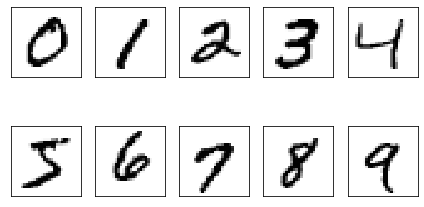

In [6]:
# Visualize the first digit of each class:
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(10):
    img = X_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('images/12_5.png', dpi=300)
plt.show()

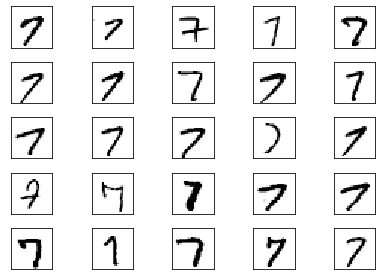

In [7]:
# Visualize 25 different versions of "7":
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(25):
    img = X_train[y_train == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('images/12_6.png', dpi=300)
plt.show()

In [8]:
np.savez_compressed('mnist_scaled.npz', 
                    X_train=X_train,
                    y_train=y_train,
                    X_test=X_test,
                    y_test=y_test)




mnist = np.load('mnist_scaled.npz')
mnist.files

['X_train', 'y_train', 'X_test', 'y_test']

In [9]:
X_train, y_train, X_test, y_test = [mnist[f] for f in ['X_train', 'y_train', 
                                    'X_test', 'y_test']]

del mnist

In [10]:
print('X_train -- Rows: %d, columns: %d %s' % (X_train.shape[0], X_train.shape[1], type(X_train)))
print('y_train -- {} {}'.format(y_train.shape, type(y_train)))
print('X_test -- Rows: %d, columns: %d %s' % (X_test.shape[0], X_test.shape[1], type(X_test)))
print('y_test -- {} {}'.format(y_test.shape, type(y_test)))

X_train -- Rows: 60000, columns: 784 <class 'numpy.ndarray'>
y_train -- (60000,) <class 'numpy.ndarray'>
X_test -- Rows: 10000, columns: 784 <class 'numpy.ndarray'>
y_test -- (10000,) <class 'numpy.ndarray'>


In [21]:
#X_train is     [n_samples, n_features]
#y_train is     [n_samples, ]               (--> mỗi 1 samples có 1 kết quả)
#y_train_enc    [n_samples, n_output]       ( = n_classlabels)

#self.b_h is    [n_hidden, ]
#self.w_h is    [n_features, n_hidden]      ( số cột của mẫu)
#self.b_out is  [n_output, ]                 ( = n_classlabels)
#self.w_out is  [n_hidden, n_output]         ( = n_classlabels)

#z_h is         [n_samples, n_hidden]        (local: tính trong batch-Backpropagation tìm self.z_h )
#a_h is         [n_samples, n_hidden]        (local: tính trong batch-Backpropagation tìm self.a_h )
#z_out is       [n_samples, n_classlabels]   (local: tính trong batch-Backpropagation tìm self.z_out )
#a_out is       [n_samples, n_classlabels]   (local: tính trong batch-Backpropagation tìm self.a_out )

#self.z_h is         [n_samples, n_hidden]        ( dùng cho forward, predict )
#self.a_h is         [n_samples, n_hidden]        ( dùng cho forward, predict )
#self.z_out is       [n_samples, n_classlabels]   ( dùng cho forward, predict )
#self.a_out is       [n_samples, n_classlabels]   ( dùng cho forward, predict )


class NeuralNetMLP(object):
    """ Feedforward neural network / Multi-layer perceptron classifier.

    Parameters
    ------------
    n_hidden : int (default: 30)
        Number of hidden units.
    l2 : float (default: 0.)
        Lambda value for L2-regularization.
        No regularization if l2=0. (default)
    epochs : int (default: 100)
        Number of passes over the training set.
    eta : float (default: 0.001)
        Learning rate.
    shuffle : bool (default: True)
        Shuffles training data every epoch if True to prevent circles.
    minibatch_size : int (default: 1)
        Number of training samples per minibatch.
    seed : int (default: None)
        Random seed for initalizing weights and shuffling.

    Attributes
    -----------
    eval_ : dict
      Dictionary collecting the cost, training accuracy,
      and validation accuracy for each epoch during training.

    """
    def __init__(self, n_hidden=30,
                 l2=0., epochs=100, eta=0.001,
                 shuffle=True, minibatch_size=1, seed=None):

        self.random = np.random.RandomState(seed)
        self.n_hidden = n_hidden
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size
    
    def _onehot(self, y, n_classes):
        """Encode labels into one-hot representation

        Parameters
        ------------
        y : array, shape = [n_samples]
            Target values.

        Returns
        -----------
        onehot : array, shape = (n_samples, n_labels)

        """
        onehot = np.zeros((n_classes, y.shape[0]))
        print(y)
        for idx, val in enumerate(y.astype(int)):
            onehot[val, idx] = 1.
            print('val, idx = {}, {} --> {}'.format(val, idx, onehot[val, idx]))
        return onehot.T
    
    def _sigmoid(self, z):
        """Compute logistic function (sigmoid)"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))
    
    #Loss Cross-Entropy
    def _compute_cost(self, y_enc, output):
        """Compute cost function.

        Parameters
        ----------
        y_enc : array, shape = (n_samples, n_labels)
            one-hot encoded class labels.
        output : array, shape = [n_samples, n_output_units]
            Activation of the output layer (forward propagation)

        Returns
        ---------
        cost : float
            Regularized cost

        """
        L2_term = (self.l2 *
                   (np.sum(self.w_h ** 2.) +
                    np.sum(self.w_out ** 2.)))

        term1 = -y_enc * (np.log(output))
        term2 = (1. - y_enc) * np.log(1. - output)
        cost = np.sum(term1 - term2) + L2_term
        
        # If you are applying this cost function to other
        # datasets where activation
        # values maybe become more extreme (closer to zero or 1)
        # you may encounter "ZeroDivisionError"s due to numerical
        # instabilities in Python & NumPy for the current implementation.
        # I.e., the code tries to evaluate log(0), which is undefined.
        # To address this issue, you could add a small constant to the
        # activation values that are passed to the log function.
        #
        # For example:
        #
        # term1 = -y_enc * (np.log(output + 1e-5))
        # term2 = (1. - y_enc) * np.log(1. - output + 1e-5)
        
        return cost
    
    def _forward(self, X):
        # step 1: net input of hidden layer
        # [n_samples, n_features] dot [n_features, n_hidden]
        # -> [n_samples, n_hidden]
        z_h = np.dot(X, self.w_h) + self.b_h   #100 x 100
        
         # step 2: activation of hidden layer
        a_h = self._sigmoid(z_h)
        
        # step 3: net input of output layer
        # [n_samples, n_hidden] dot [n_hidden, n_classlabels]
        # -> [n_samples, n_classlabels]

        z_out = np.dot(a_h, self.w_out) + self.b_out #100 x 10
        
        # step 4: activation output layer
        a_out = self._sigmoid(z_out)
        
        
        #print('z_h shape -- {} {}'.format(z_h.shape, type(z_h)))
        #print('a_h shape -- {} {}'.format(a_h.shape, type(a_h)))
        #print('z_out shape -- {} {}'.format(z_out.shape, type(z_out)))
        #print('a_out shape -- {} {}'.format(a_out.shape, type(z_h)))
        
        return z_h, a_h, z_out, a_out    
    
    
    def predict(self, X):
        """Predict class labels

        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
            Input layer with original features.

        Returns:
        ----------
        y_pred : array, shape = [n_samples]
            Predicted class labels.

        """
        z_h, a_h, z_out, a_out = self._forward(X)
        y_pred = np.argmax(z_out, axis=1)
        return y_pred
    
    

        
        
    def fit(self, X_train, y_train, X_valid, y_valid):
        print('y_train -- {} {}'.format(y_train.shape, type(y_train)))
        print('X_train -- {} {}'.format(X_train.shape, type(X_train)))
        n_output = np.unique(y_train).shape[0]  # number of class labels
        
        n_features = X_train.shape[1] #784
        print('n_output -- {} {}'.format(n_output, type(n_output)))
        print('n_features -- {} {}'.format(n_features, type(n_features)))
        print((y_train))
        
        ########################
        # Weight initialization
        ########################
        # weights for input -> hidden
        self.b_h = np.zeros(self.n_hidden)
        self.w_h = self.random.normal(loc=0.0, scale=0.1,
                                      size=(n_features, self.n_hidden))
        
        print('self.b_h -- {} {}'.format(self.b_h.shape, type(self.b_h)))
        print('self.w_h -- {} {}'.format(self.w_h.shape, type(self.w_h)))
        
         # weights for hidden -> output
        self.b_out = np.zeros(n_output)
        self.w_out = self.random.normal(loc=0.0, scale=0.1,
                                        size=(self.n_hidden, n_output))
        
        print('self.b_out -- {} {}'.format(self.b_out.shape, type(self.b_out)))
        print('self.w_out -- {} {}'.format(self.w_out.shape, type(self.w_out)))
        
        #--------------------------------------------------------------------------
        epoch_strlen = len(str(self.epochs))  # for progress formatting
        self.eval_ = {'cost': [], 'train_acc': [], 'valid_acc': []}

        #--------------------------------------------------------------------------
        y_train_enc = self._onehot(y_train, n_output)
        print('y_train_enc {}'.format(y_train_enc))
        print('y_train_enc shape -- {} {}'.format(y_train_enc.shape, type(y_train_enc)))
        
        # iterate over training epochs
        for i in range(self.epochs):
            # iterate over minibatches
            indices = np.arange(X_train.shape[0])
            
            #xáo trộn indices
            if self.shuffle:
                self.random.shuffle(indices)
            
            #xử lý data theo từng batch là minibatch_size
            for start_idx in range(0, indices.shape[0] - self.minibatch_size + 1, self.minibatch_size):
                batch_idx = indices[start_idx:start_idx + self.minibatch_size]
                #print('{}.batch_idx = {}'.format(start_idx, batch_idx))
                
                # forward propagation
               # print('X_train[batch_idx] -- {} {}'.format(X_train[batch_idx].shape, type(X_train[batch_idx])))
                z_h, a_h, z_out, a_out = self._forward(X_train[batch_idx])
                
                #X_train is     [n_samples, n_features]
                #y_train is     [n_samples, ]               (--> mỗi 1 samples có 1 kết quả)
                #y_train_enc    [n_samples, n_output]       ( = n_classlabels)
                
                #self.b_h is    [n_hidden, ]
                #self.w_h is    [n_features, n_hidden]      ( số cột của mẫu)
                #self.b_out is  [n_output, ]                 ( = n_classlabels)
                #self.w_out is  [n_hidden, n_output]         ( = n_classlabels)
                
                #z_h is         [n_samples, n_hidden]        (local: tính trong batch-Backpropagation tìm self.z_h )
                #a_h is         [n_samples, n_hidden]        (local: tính trong batch-Backpropagation tìm self.a_h )
                #z_out is       [n_samples, n_classlabels]   (local: tính trong batch-Backpropagation tìm self.z_out )
                #a_out is       [n_samples, n_classlabels]   (local: tính trong batch-Backpropagation tìm self.a_out )
                
                #self.z_h is         [n_samples, n_hidden]        ( dùng cho forward, predict )
                #self.a_h is         [n_samples, n_hidden]        ( dùng cho forward, predict )
                #self.z_out is       [n_samples, n_classlabels]   ( dùng cho forward, predict )
                #self.a_out is       [n_samples, n_classlabels]   ( dùng cho forward, predict )
                
                
                
                ##################
                # Backpropagation: (hàm cost: Loss Cross-Entropy )
                ##################
                # [n_samples, n_classlabels]
                sigma_out = a_out - y_train_enc[batch_idx]
                
                # [n_samples, n_hidden]
                sigmoid_derivative_h = a_h * (1. - a_h) # đạo hàm của hàm sigmoid theo hidden 
                
                
                # [n_samples, n_classlabels] dot [n_classlabels, n_hidden]
                # -> [n_samples, n_hidden]
                sigma_h = (np.dot(sigma_out, self.w_out.T) * sigmoid_derivative_h)
                
                
                # [n_features, n_samples] dot [n_samples, n_hidden]
                # -> [n_features, n_hidden]
                grad_w_h = np.dot(X_train[batch_idx].T, sigma_h)
                grad_b_h = np.sum(sigma_h, axis=0)
                
                # [n_hidden, n_samples] dot [n_samples, n_classlabels]
                # -> [n_hidden, n_classlabels]
                grad_w_out = np.dot(a_h.T, sigma_out)
                grad_b_out = np.sum(sigma_out, axis=0)
                
                
                # Regularization and weight updates
                delta_w_h = (grad_w_h + self.l2*self.w_h)
                delta_b_h = grad_b_h # bias is not regularized
                self.w_h -= self.eta * delta_w_h
                self.b_h -= self.eta * delta_b_h

                delta_w_out = (grad_w_out + self.l2*self.w_out)
                delta_b_out = grad_b_out  # bias is not regularized
                self.w_out -= self.eta * delta_w_out
                self.b_out -= self.eta * delta_b_out
                
                
                #break #to test single 
                
            #############
            # Evaluation
            #############
            # Evaluation after each epoch during training
            z_h, a_h, z_out, a_out = self._forward(X_train)
            cost = self._compute_cost(y_enc=y_train_enc,
                                      output=a_out)
            
            
            y_train_pred = self.predict(X_train)
            y_valid_pred = self.predict(X_valid)
            
            
            train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float) /
                         X_train.shape[0])
            valid_acc = ((np.sum(y_valid == y_valid_pred)).astype(np.float) /
                         X_valid.shape[0])

            sys.stderr.write('\r%0*d/%d | Cost: %.2f '
                             '| Train/Valid Acc.: %.2f%%/%.2f%% ' %
                             (epoch_strlen, i+1, self.epochs, cost,
                              train_acc*100, valid_acc*100))
            sys.stderr.flush()

            self.eval_['cost'].append(cost)
            self.eval_['train_acc'].append(train_acc)
            self.eval_['valid_acc'].append(valid_acc)
        return self
            

In [22]:
n_epochs = 1
nn = NeuralNetMLP(n_hidden=100, 
                  l2=0.01, 
                  epochs=n_epochs, 
                  eta=0.0005,
                  minibatch_size=100, 
                  shuffle=False,  #True: xạo trộn
                  seed=1)

nn.fit(X_train=X_train[:55000], 
       y_train=y_train[:55000],
       X_valid=X_train[55000:],
       y_valid=y_train[55000:])

y_train -- (55000,) <class 'numpy.ndarray'>
X_train -- (55000, 784) <class 'numpy.ndarray'>
n_output -- 10 <class 'int'>
n_features -- 784 <class 'int'>
[5 0 4 ... 0 4 0]
self.b_h -- (100,) <class 'numpy.ndarray'>
self.w_h -- (784, 100) <class 'numpy.ndarray'>
self.b_out -- (10,) <class 'numpy.ndarray'>
self.w_out -- (100, 10) <class 'numpy.ndarray'>
[5 0 4 ... 0 4 0]
val, idx = 5, 0 --> 1.0
val, idx = 0, 1 --> 1.0
val, idx = 4, 2 --> 1.0
val, idx = 1, 3 --> 1.0
val, idx = 9, 4 --> 1.0
val, idx = 2, 5 --> 1.0
val, idx = 1, 6 --> 1.0
val, idx = 3, 7 --> 1.0
val, idx = 1, 8 --> 1.0
val, idx = 4, 9 --> 1.0
val, idx = 3, 10 --> 1.0
val, idx = 5, 11 --> 1.0
val, idx = 3, 12 --> 1.0
val, idx = 6, 13 --> 1.0
val, idx = 1, 14 --> 1.0
val, idx = 7, 15 --> 1.0
val, idx = 2, 16 --> 1.0
val, idx = 8, 17 --> 1.0
val, idx = 6, 18 --> 1.0
val, idx = 9, 19 --> 1.0
val, idx = 4, 20 --> 1.0
val, idx = 0, 21 --> 1.0
val, idx = 9, 22 --> 1.0
val, idx = 1, 23 --> 1.0
val, idx = 1, 24 --> 1.0
val, idx = 2, 

val, idx = 9, 2321 --> 1.0
val, idx = 2, 2322 --> 1.0
val, idx = 4, 2323 --> 1.0
val, idx = 6, 2324 --> 1.0
val, idx = 0, 2325 --> 1.0
val, idx = 1, 2326 --> 1.0
val, idx = 0, 2327 --> 1.0
val, idx = 5, 2328 --> 1.0
val, idx = 5, 2329 --> 1.0
val, idx = 5, 2330 --> 1.0
val, idx = 9, 2331 --> 1.0
val, idx = 2, 2332 --> 1.0
val, idx = 0, 2333 --> 1.0
val, idx = 4, 2334 --> 1.0
val, idx = 1, 2335 --> 1.0
val, idx = 1, 2336 --> 1.0
val, idx = 2, 2337 --> 1.0
val, idx = 4, 2338 --> 1.0
val, idx = 3, 2339 --> 1.0
val, idx = 0, 2340 --> 1.0
val, idx = 4, 2341 --> 1.0
val, idx = 2, 2342 --> 1.0
val, idx = 5, 2343 --> 1.0
val, idx = 7, 2344 --> 1.0
val, idx = 6, 2345 --> 1.0
val, idx = 2, 2346 --> 1.0
val, idx = 7, 2347 --> 1.0
val, idx = 7, 2348 --> 1.0
val, idx = 8, 2349 --> 1.0
val, idx = 3, 2350 --> 1.0
val, idx = 9, 2351 --> 1.0
val, idx = 0, 2352 --> 1.0
val, idx = 0, 2353 --> 1.0
val, idx = 2, 2354 --> 1.0
val, idx = 1, 2355 --> 1.0
val, idx = 1, 2356 --> 1.0
val, idx = 2, 2357 --> 1.0
v

val, idx = 7, 4809 --> 1.0
val, idx = 1, 4810 --> 1.0
val, idx = 9, 4811 --> 1.0
val, idx = 4, 4812 --> 1.0
val, idx = 1, 4813 --> 1.0
val, idx = 8, 4814 --> 1.0
val, idx = 1, 4815 --> 1.0
val, idx = 9, 4816 --> 1.0
val, idx = 6, 4817 --> 1.0
val, idx = 6, 4818 --> 1.0
val, idx = 2, 4819 --> 1.0
val, idx = 5, 4820 --> 1.0
val, idx = 1, 4821 --> 1.0
val, idx = 4, 4822 --> 1.0
val, idx = 3, 4823 --> 1.0
val, idx = 9, 4824 --> 1.0
val, idx = 8, 4825 --> 1.0
val, idx = 9, 4826 --> 1.0
val, idx = 6, 4827 --> 1.0
val, idx = 6, 4828 --> 1.0
val, idx = 4, 4829 --> 1.0
val, idx = 9, 4830 --> 1.0
val, idx = 9, 4831 --> 1.0
val, idx = 7, 4832 --> 1.0
val, idx = 4, 4833 --> 1.0
val, idx = 8, 4834 --> 1.0
val, idx = 2, 4835 --> 1.0
val, idx = 3, 4836 --> 1.0
val, idx = 4, 4837 --> 1.0
val, idx = 4, 4838 --> 1.0
val, idx = 4, 4839 --> 1.0
val, idx = 7, 4840 --> 1.0
val, idx = 6, 4841 --> 1.0
val, idx = 7, 4842 --> 1.0
val, idx = 2, 4843 --> 1.0
val, idx = 5, 4844 --> 1.0
val, idx = 5, 4845 --> 1.0
v

val, idx = 9, 7200 --> 1.0
val, idx = 9, 7201 --> 1.0
val, idx = 6, 7202 --> 1.0
val, idx = 0, 7203 --> 1.0
val, idx = 4, 7204 --> 1.0
val, idx = 1, 7205 --> 1.0
val, idx = 6, 7206 --> 1.0
val, idx = 2, 7207 --> 1.0
val, idx = 9, 7208 --> 1.0
val, idx = 3, 7209 --> 1.0
val, idx = 7, 7210 --> 1.0
val, idx = 4, 7211 --> 1.0
val, idx = 6, 7212 --> 1.0
val, idx = 7, 7213 --> 1.0
val, idx = 3, 7214 --> 1.0
val, idx = 8, 7215 --> 1.0
val, idx = 5, 7216 --> 1.0
val, idx = 9, 7217 --> 1.0
val, idx = 8, 7218 --> 1.0
val, idx = 0, 7219 --> 1.0
val, idx = 6, 7220 --> 1.0
val, idx = 1, 7221 --> 1.0
val, idx = 1, 7222 --> 1.0
val, idx = 2, 7223 --> 1.0
val, idx = 6, 7224 --> 1.0
val, idx = 3, 7225 --> 1.0
val, idx = 7, 7226 --> 1.0
val, idx = 4, 7227 --> 1.0
val, idx = 8, 7228 --> 1.0
val, idx = 7, 7229 --> 1.0
val, idx = 6, 7230 --> 1.0
val, idx = 8, 7231 --> 1.0
val, idx = 5, 7232 --> 1.0
val, idx = 9, 7233 --> 1.0
val, idx = 1, 7234 --> 1.0
val, idx = 5, 7235 --> 1.0
val, idx = 7, 7236 --> 1.0
v

val, idx = 9, 9751 --> 1.0
val, idx = 9, 9752 --> 1.0
val, idx = 0, 9753 --> 1.0
val, idx = 9, 9754 --> 1.0
val, idx = 1, 9755 --> 1.0
val, idx = 2, 9756 --> 1.0
val, idx = 2, 9757 --> 1.0
val, idx = 9, 9758 --> 1.0
val, idx = 3, 9759 --> 1.0
val, idx = 6, 9760 --> 1.0
val, idx = 4, 9761 --> 1.0
val, idx = 8, 9762 --> 1.0
val, idx = 5, 9763 --> 1.0
val, idx = 8, 9764 --> 1.0
val, idx = 6, 9765 --> 1.0
val, idx = 3, 9766 --> 1.0
val, idx = 7, 9767 --> 1.0
val, idx = 7, 9768 --> 1.0
val, idx = 8, 9769 --> 1.0
val, idx = 5, 9770 --> 1.0
val, idx = 9, 9771 --> 1.0
val, idx = 2, 9772 --> 1.0
val, idx = 0, 9773 --> 1.0
val, idx = 7, 9774 --> 1.0
val, idx = 1, 9775 --> 1.0
val, idx = 2, 9776 --> 1.0
val, idx = 2, 9777 --> 1.0
val, idx = 3, 9778 --> 1.0
val, idx = 3, 9779 --> 1.0
val, idx = 2, 9780 --> 1.0
val, idx = 4, 9781 --> 1.0
val, idx = 8, 9782 --> 1.0
val, idx = 5, 9783 --> 1.0
val, idx = 9, 9784 --> 1.0
val, idx = 6, 9785 --> 1.0
val, idx = 3, 9786 --> 1.0
val, idx = 7, 9787 --> 1.0
v

val, idx = 6, 12199 --> 1.0
val, idx = 9, 12200 --> 1.0
val, idx = 6, 12201 --> 1.0
val, idx = 9, 12202 --> 1.0
val, idx = 9, 12203 --> 1.0
val, idx = 2, 12204 --> 1.0
val, idx = 0, 12205 --> 1.0
val, idx = 7, 12206 --> 1.0
val, idx = 1, 12207 --> 1.0
val, idx = 7, 12208 --> 1.0
val, idx = 1, 12209 --> 1.0
val, idx = 5, 12210 --> 1.0
val, idx = 3, 12211 --> 1.0
val, idx = 1, 12212 --> 1.0
val, idx = 2, 12213 --> 1.0
val, idx = 3, 12214 --> 1.0
val, idx = 1, 12215 --> 1.0
val, idx = 6, 12216 --> 1.0
val, idx = 0, 12217 --> 1.0
val, idx = 3, 12218 --> 1.0
val, idx = 0, 12219 --> 1.0
val, idx = 6, 12220 --> 1.0
val, idx = 1, 12221 --> 1.0
val, idx = 3, 12222 --> 1.0
val, idx = 2, 12223 --> 1.0
val, idx = 4, 12224 --> 1.0
val, idx = 3, 12225 --> 1.0
val, idx = 1, 12226 --> 1.0
val, idx = 4, 12227 --> 1.0
val, idx = 3, 12228 --> 1.0
val, idx = 5, 12229 --> 1.0
val, idx = 1, 12230 --> 1.0
val, idx = 6, 12231 --> 1.0
val, idx = 5, 12232 --> 1.0
val, idx = 7, 12233 --> 1.0
val, idx = 2, 12234 

val, idx = 9, 14762 --> 1.0
val, idx = 2, 14763 --> 1.0
val, idx = 6, 14764 --> 1.0
val, idx = 3, 14765 --> 1.0
val, idx = 8, 14766 --> 1.0
val, idx = 1, 14767 --> 1.0
val, idx = 6, 14768 --> 1.0
val, idx = 4, 14769 --> 1.0
val, idx = 7, 14770 --> 1.0
val, idx = 2, 14771 --> 1.0
val, idx = 8, 14772 --> 1.0
val, idx = 0, 14773 --> 1.0
val, idx = 4, 14774 --> 1.0
val, idx = 0, 14775 --> 1.0
val, idx = 2, 14776 --> 1.0
val, idx = 7, 14777 --> 1.0
val, idx = 6, 14778 --> 1.0
val, idx = 8, 14779 --> 1.0
val, idx = 9, 14780 --> 1.0
val, idx = 4, 14781 --> 1.0
val, idx = 8, 14782 --> 1.0
val, idx = 6, 14783 --> 1.0
val, idx = 6, 14784 --> 1.0
val, idx = 4, 14785 --> 1.0
val, idx = 3, 14786 --> 1.0
val, idx = 9, 14787 --> 1.0
val, idx = 4, 14788 --> 1.0
val, idx = 3, 14789 --> 1.0
val, idx = 9, 14790 --> 1.0
val, idx = 8, 14791 --> 1.0
val, idx = 3, 14792 --> 1.0
val, idx = 4, 14793 --> 1.0
val, idx = 1, 14794 --> 1.0
val, idx = 7, 14795 --> 1.0
val, idx = 9, 14796 --> 1.0
val, idx = 2, 14797 

val, idx = 7, 17177 --> 1.0
val, idx = 8, 17178 --> 1.0
val, idx = 8, 17179 --> 1.0
val, idx = 1, 17180 --> 1.0
val, idx = 9, 17181 --> 1.0
val, idx = 4, 17182 --> 1.0
val, idx = 7, 17183 --> 1.0
val, idx = 1, 17184 --> 1.0
val, idx = 7, 17185 --> 1.0
val, idx = 9, 17186 --> 1.0
val, idx = 0, 17187 --> 1.0
val, idx = 2, 17188 --> 1.0
val, idx = 3, 17189 --> 1.0
val, idx = 9, 17190 --> 1.0
val, idx = 1, 17191 --> 1.0
val, idx = 3, 17192 --> 1.0
val, idx = 8, 17193 --> 1.0
val, idx = 8, 17194 --> 1.0
val, idx = 9, 17195 --> 1.0
val, idx = 8, 17196 --> 1.0
val, idx = 8, 17197 --> 1.0
val, idx = 4, 17198 --> 1.0
val, idx = 6, 17199 --> 1.0
val, idx = 0, 17200 --> 1.0
val, idx = 5, 17201 --> 1.0
val, idx = 2, 17202 --> 1.0
val, idx = 4, 17203 --> 1.0
val, idx = 6, 17204 --> 1.0
val, idx = 7, 17205 --> 1.0
val, idx = 7, 17206 --> 1.0
val, idx = 3, 17207 --> 1.0
val, idx = 3, 17208 --> 1.0
val, idx = 1, 17209 --> 1.0
val, idx = 0, 17210 --> 1.0
val, idx = 9, 17211 --> 1.0
val, idx = 2, 17212 

val, idx = 7, 19683 --> 1.0
val, idx = 6, 19684 --> 1.0
val, idx = 8, 19685 --> 1.0
val, idx = 0, 19686 --> 1.0
val, idx = 9, 19687 --> 1.0
val, idx = 2, 19688 --> 1.0
val, idx = 0, 19689 --> 1.0
val, idx = 9, 19690 --> 1.0
val, idx = 1, 19691 --> 1.0
val, idx = 8, 19692 --> 1.0
val, idx = 2, 19693 --> 1.0
val, idx = 2, 19694 --> 1.0
val, idx = 3, 19695 --> 1.0
val, idx = 9, 19696 --> 1.0
val, idx = 4, 19697 --> 1.0
val, idx = 6, 19698 --> 1.0
val, idx = 5, 19699 --> 1.0
val, idx = 4, 19700 --> 1.0
val, idx = 6, 19701 --> 1.0
val, idx = 5, 19702 --> 1.0
val, idx = 7, 19703 --> 1.0
val, idx = 7, 19704 --> 1.0
val, idx = 8, 19705 --> 1.0
val, idx = 5, 19706 --> 1.0
val, idx = 9, 19707 --> 1.0
val, idx = 3, 19708 --> 1.0
val, idx = 0, 19709 --> 1.0
val, idx = 6, 19710 --> 1.0
val, idx = 8, 19711 --> 1.0
val, idx = 6, 19712 --> 1.0
val, idx = 3, 19713 --> 1.0
val, idx = 0, 19714 --> 1.0
val, idx = 9, 19715 --> 1.0
val, idx = 8, 19716 --> 1.0
val, idx = 5, 19717 --> 1.0
val, idx = 9, 19718 

val, idx = 4, 22197 --> 1.0
val, idx = 2, 22198 --> 1.0
val, idx = 2, 22199 --> 1.0
val, idx = 2, 22200 --> 1.0
val, idx = 8, 22201 --> 1.0
val, idx = 0, 22202 --> 1.0
val, idx = 2, 22203 --> 1.0
val, idx = 3, 22204 --> 1.0
val, idx = 5, 22205 --> 1.0
val, idx = 3, 22206 --> 1.0
val, idx = 1, 22207 --> 1.0
val, idx = 0, 22208 --> 1.0
val, idx = 0, 22209 --> 1.0
val, idx = 6, 22210 --> 1.0
val, idx = 5, 22211 --> 1.0
val, idx = 6, 22212 --> 1.0
val, idx = 0, 22213 --> 1.0
val, idx = 1, 22214 --> 1.0
val, idx = 6, 22215 --> 1.0
val, idx = 9, 22216 --> 1.0
val, idx = 2, 22217 --> 1.0
val, idx = 3, 22218 --> 1.0
val, idx = 3, 22219 --> 1.0
val, idx = 7, 22220 --> 1.0
val, idx = 6, 22221 --> 1.0
val, idx = 1, 22222 --> 1.0
val, idx = 9, 22223 --> 1.0
val, idx = 0, 22224 --> 1.0
val, idx = 0, 22225 --> 1.0
val, idx = 2, 22226 --> 1.0
val, idx = 1, 22227 --> 1.0
val, idx = 7, 22228 --> 1.0
val, idx = 2, 22229 --> 1.0
val, idx = 9, 22230 --> 1.0
val, idx = 3, 22231 --> 1.0
val, idx = 2, 22232 

val, idx = 1, 24628 --> 1.0
val, idx = 0, 24629 --> 1.0
val, idx = 5, 24630 --> 1.0
val, idx = 1, 24631 --> 1.0
val, idx = 2, 24632 --> 1.0
val, idx = 2, 24633 --> 1.0
val, idx = 1, 24634 --> 1.0
val, idx = 3, 24635 --> 1.0
val, idx = 0, 24636 --> 1.0
val, idx = 4, 24637 --> 1.0
val, idx = 6, 24638 --> 1.0
val, idx = 7, 24639 --> 1.0
val, idx = 0, 24640 --> 1.0
val, idx = 8, 24641 --> 1.0
val, idx = 4, 24642 --> 1.0
val, idx = 9, 24643 --> 1.0
val, idx = 7, 24644 --> 1.0
val, idx = 0, 24645 --> 1.0
val, idx = 8, 24646 --> 1.0
val, idx = 1, 24647 --> 1.0
val, idx = 4, 24648 --> 1.0
val, idx = 2, 24649 --> 1.0
val, idx = 5, 24650 --> 1.0
val, idx = 3, 24651 --> 1.0
val, idx = 7, 24652 --> 1.0
val, idx = 4, 24653 --> 1.0
val, idx = 8, 24654 --> 1.0
val, idx = 7, 24655 --> 1.0
val, idx = 6, 24656 --> 1.0
val, idx = 8, 24657 --> 1.0
val, idx = 8, 24658 --> 1.0
val, idx = 9, 24659 --> 1.0
val, idx = 5, 24660 --> 1.0
val, idx = 0, 24661 --> 1.0
val, idx = 7, 24662 --> 1.0
val, idx = 1, 24663 

val, idx = 3, 27167 --> 1.0
val, idx = 7, 27168 --> 1.0
val, idx = 6, 27169 --> 1.0
val, idx = 0, 27170 --> 1.0
val, idx = 2, 27171 --> 1.0
val, idx = 3, 27172 --> 1.0
val, idx = 3, 27173 --> 1.0
val, idx = 9, 27174 --> 1.0
val, idx = 6, 27175 --> 1.0
val, idx = 5, 27176 --> 1.0
val, idx = 8, 27177 --> 1.0
val, idx = 2, 27178 --> 1.0
val, idx = 5, 27179 --> 1.0
val, idx = 4, 27180 --> 1.0
val, idx = 2, 27181 --> 1.0
val, idx = 1, 27182 --> 1.0
val, idx = 3, 27183 --> 1.0
val, idx = 7, 27184 --> 1.0
val, idx = 8, 27185 --> 1.0
val, idx = 2, 27186 --> 1.0
val, idx = 1, 27187 --> 1.0
val, idx = 2, 27188 --> 1.0
val, idx = 2, 27189 --> 1.0
val, idx = 6, 27190 --> 1.0
val, idx = 9, 27191 --> 1.0
val, idx = 2, 27192 --> 1.0
val, idx = 5, 27193 --> 1.0
val, idx = 7, 27194 --> 1.0
val, idx = 8, 27195 --> 1.0
val, idx = 4, 27196 --> 1.0
val, idx = 8, 27197 --> 1.0
val, idx = 6, 27198 --> 1.0
val, idx = 7, 27199 --> 1.0
val, idx = 0, 27200 --> 1.0
val, idx = 1, 27201 --> 1.0
val, idx = 1, 27202 

val, idx = 2, 29698 --> 1.0
val, idx = 2, 29699 --> 1.0
val, idx = 8, 29700 --> 1.0
val, idx = 3, 29701 --> 1.0
val, idx = 8, 29702 --> 1.0
val, idx = 4, 29703 --> 1.0
val, idx = 0, 29704 --> 1.0
val, idx = 5, 29705 --> 1.0
val, idx = 0, 29706 --> 1.0
val, idx = 6, 29707 --> 1.0
val, idx = 5, 29708 --> 1.0
val, idx = 7, 29709 --> 1.0
val, idx = 9, 29710 --> 1.0
val, idx = 8, 29711 --> 1.0
val, idx = 5, 29712 --> 1.0
val, idx = 0, 29713 --> 1.0
val, idx = 7, 29714 --> 1.0
val, idx = 1, 29715 --> 1.0
val, idx = 2, 29716 --> 1.0
val, idx = 2, 29717 --> 1.0
val, idx = 0, 29718 --> 1.0
val, idx = 3, 29719 --> 1.0
val, idx = 2, 29720 --> 1.0
val, idx = 4, 29721 --> 1.0
val, idx = 8, 29722 --> 1.0
val, idx = 5, 29723 --> 1.0
val, idx = 9, 29724 --> 1.0
val, idx = 6, 29725 --> 1.0
val, idx = 2, 29726 --> 1.0
val, idx = 7, 29727 --> 1.0
val, idx = 6, 29728 --> 1.0
val, idx = 8, 29729 --> 1.0
val, idx = 7, 29730 --> 1.0
val, idx = 9, 29731 --> 1.0
val, idx = 0, 29732 --> 1.0
val, idx = 7, 29733 

val, idx = 3, 31989 --> 1.0
val, idx = 1, 31990 --> 1.0
val, idx = 7, 31991 --> 1.0
val, idx = 7, 31992 --> 1.0
val, idx = 1, 31993 --> 1.0
val, idx = 4, 31994 --> 1.0
val, idx = 0, 31995 --> 1.0
val, idx = 7, 31996 --> 1.0
val, idx = 7, 31997 --> 1.0
val, idx = 6, 31998 --> 1.0
val, idx = 5, 31999 --> 1.0
val, idx = 8, 32000 --> 1.0
val, idx = 5, 32001 --> 1.0
val, idx = 6, 32002 --> 1.0
val, idx = 6, 32003 --> 1.0
val, idx = 7, 32004 --> 1.0
val, idx = 1, 32005 --> 1.0
val, idx = 6, 32006 --> 1.0
val, idx = 0, 32007 --> 1.0
val, idx = 2, 32008 --> 1.0
val, idx = 0, 32009 --> 1.0
val, idx = 2, 32010 --> 1.0
val, idx = 8, 32011 --> 1.0
val, idx = 8, 32012 --> 1.0
val, idx = 3, 32013 --> 1.0
val, idx = 4, 32014 --> 1.0
val, idx = 4, 32015 --> 1.0
val, idx = 9, 32016 --> 1.0
val, idx = 3, 32017 --> 1.0
val, idx = 8, 32018 --> 1.0
val, idx = 1, 32019 --> 1.0
val, idx = 4, 32020 --> 1.0
val, idx = 9, 32021 --> 1.0
val, idx = 2, 32022 --> 1.0
val, idx = 5, 32023 --> 1.0
val, idx = 2, 32024 

val, idx = 6, 34255 --> 1.0
val, idx = 2, 34256 --> 1.0
val, idx = 8, 34257 --> 1.0
val, idx = 9, 34258 --> 1.0
val, idx = 3, 34259 --> 1.0
val, idx = 6, 34260 --> 1.0
val, idx = 1, 34261 --> 1.0
val, idx = 0, 34262 --> 1.0
val, idx = 1, 34263 --> 1.0
val, idx = 1, 34264 --> 1.0
val, idx = 7, 34265 --> 1.0
val, idx = 4, 34266 --> 1.0
val, idx = 7, 34267 --> 1.0
val, idx = 3, 34268 --> 1.0
val, idx = 1, 34269 --> 1.0
val, idx = 5, 34270 --> 1.0
val, idx = 6, 34271 --> 1.0
val, idx = 1, 34272 --> 1.0
val, idx = 0, 34273 --> 1.0
val, idx = 5, 34274 --> 1.0
val, idx = 4, 34275 --> 1.0
val, idx = 5, 34276 --> 1.0
val, idx = 6, 34277 --> 1.0
val, idx = 7, 34278 --> 1.0
val, idx = 4, 34279 --> 1.0
val, idx = 9, 34280 --> 1.0
val, idx = 4, 34281 --> 1.0
val, idx = 1, 34282 --> 1.0
val, idx = 0, 34283 --> 1.0
val, idx = 6, 34284 --> 1.0
val, idx = 6, 34285 --> 1.0
val, idx = 8, 34286 --> 1.0
val, idx = 2, 34287 --> 1.0
val, idx = 5, 34288 --> 1.0
val, idx = 3, 34289 --> 1.0
val, idx = 4, 34290 

val, idx = 9, 36678 --> 1.0
val, idx = 9, 36679 --> 1.0
val, idx = 2, 36680 --> 1.0
val, idx = 8, 36681 --> 1.0
val, idx = 1, 36682 --> 1.0
val, idx = 5, 36683 --> 1.0
val, idx = 3, 36684 --> 1.0
val, idx = 2, 36685 --> 1.0
val, idx = 6, 36686 --> 1.0
val, idx = 1, 36687 --> 1.0
val, idx = 7, 36688 --> 1.0
val, idx = 0, 36689 --> 1.0
val, idx = 5, 36690 --> 1.0
val, idx = 7, 36691 --> 1.0
val, idx = 0, 36692 --> 1.0
val, idx = 2, 36693 --> 1.0
val, idx = 2, 36694 --> 1.0
val, idx = 5, 36695 --> 1.0
val, idx = 8, 36696 --> 1.0
val, idx = 5, 36697 --> 1.0
val, idx = 6, 36698 --> 1.0
val, idx = 6, 36699 --> 1.0
val, idx = 7, 36700 --> 1.0
val, idx = 6, 36701 --> 1.0
val, idx = 6, 36702 --> 1.0
val, idx = 6, 36703 --> 1.0
val, idx = 2, 36704 --> 1.0
val, idx = 3, 36705 --> 1.0
val, idx = 4, 36706 --> 1.0
val, idx = 3, 36707 --> 1.0
val, idx = 8, 36708 --> 1.0
val, idx = 3, 36709 --> 1.0
val, idx = 8, 36710 --> 1.0
val, idx = 1, 36711 --> 1.0
val, idx = 0, 36712 --> 1.0
val, idx = 7, 36713 

val, idx = 7, 39107 --> 1.0
val, idx = 3, 39108 --> 1.0
val, idx = 8, 39109 --> 1.0
val, idx = 4, 39110 --> 1.0
val, idx = 9, 39111 --> 1.0
val, idx = 6, 39112 --> 1.0
val, idx = 7, 39113 --> 1.0
val, idx = 5, 39114 --> 1.0
val, idx = 0, 39115 --> 1.0
val, idx = 3, 39116 --> 1.0
val, idx = 4, 39117 --> 1.0
val, idx = 2, 39118 --> 1.0
val, idx = 0, 39119 --> 1.0
val, idx = 5, 39120 --> 1.0
val, idx = 6, 39121 --> 1.0
val, idx = 3, 39122 --> 1.0
val, idx = 4, 39123 --> 1.0
val, idx = 3, 39124 --> 1.0
val, idx = 3, 39125 --> 1.0
val, idx = 5, 39126 --> 1.0
val, idx = 3, 39127 --> 1.0
val, idx = 4, 39128 --> 1.0
val, idx = 4, 39129 --> 1.0
val, idx = 6, 39130 --> 1.0
val, idx = 8, 39131 --> 1.0
val, idx = 5, 39132 --> 1.0
val, idx = 7, 39133 --> 1.0
val, idx = 9, 39134 --> 1.0
val, idx = 8, 39135 --> 1.0
val, idx = 3, 39136 --> 1.0
val, idx = 6, 39137 --> 1.0
val, idx = 1, 39138 --> 1.0
val, idx = 9, 39139 --> 1.0
val, idx = 3, 39140 --> 1.0
val, idx = 8, 39141 --> 1.0
val, idx = 8, 39142 

val, idx = 1, 41474 --> 1.0
val, idx = 5, 41475 --> 1.0
val, idx = 3, 41476 --> 1.0
val, idx = 6, 41477 --> 1.0
val, idx = 2, 41478 --> 1.0
val, idx = 7, 41479 --> 1.0
val, idx = 9, 41480 --> 1.0
val, idx = 8, 41481 --> 1.0
val, idx = 4, 41482 --> 1.0
val, idx = 9, 41483 --> 1.0
val, idx = 2, 41484 --> 1.0
val, idx = 0, 41485 --> 1.0
val, idx = 5, 41486 --> 1.0
val, idx = 1, 41487 --> 1.0
val, idx = 6, 41488 --> 1.0
val, idx = 2, 41489 --> 1.0
val, idx = 0, 41490 --> 1.0
val, idx = 3, 41491 --> 1.0
val, idx = 1, 41492 --> 1.0
val, idx = 7, 41493 --> 1.0
val, idx = 3, 41494 --> 1.0
val, idx = 8, 41495 --> 1.0
val, idx = 7, 41496 --> 1.0
val, idx = 9, 41497 --> 1.0
val, idx = 5, 41498 --> 1.0
val, idx = 4, 41499 --> 1.0
val, idx = 6, 41500 --> 1.0
val, idx = 9, 41501 --> 1.0
val, idx = 9, 41502 --> 1.0
val, idx = 9, 41503 --> 1.0
val, idx = 8, 41504 --> 1.0
val, idx = 8, 41505 --> 1.0
val, idx = 0, 41506 --> 1.0
val, idx = 3, 41507 --> 1.0
val, idx = 6, 41508 --> 1.0
val, idx = 5, 41509 

val, idx = 2, 43996 --> 1.0
val, idx = 3, 43997 --> 1.0
val, idx = 7, 43998 --> 1.0
val, idx = 9, 43999 --> 1.0
val, idx = 0, 44000 --> 1.0
val, idx = 9, 44001 --> 1.0
val, idx = 8, 44002 --> 1.0
val, idx = 5, 44003 --> 1.0
val, idx = 3, 44004 --> 1.0
val, idx = 7, 44005 --> 1.0
val, idx = 5, 44006 --> 1.0
val, idx = 8, 44007 --> 1.0
val, idx = 9, 44008 --> 1.0
val, idx = 5, 44009 --> 1.0
val, idx = 9, 44010 --> 1.0
val, idx = 6, 44011 --> 1.0
val, idx = 1, 44012 --> 1.0
val, idx = 4, 44013 --> 1.0
val, idx = 5, 44014 --> 1.0
val, idx = 7, 44015 --> 1.0
val, idx = 9, 44016 --> 1.0
val, idx = 6, 44017 --> 1.0
val, idx = 5, 44018 --> 1.0
val, idx = 2, 44019 --> 1.0
val, idx = 3, 44020 --> 1.0
val, idx = 2, 44021 --> 1.0
val, idx = 9, 44022 --> 1.0
val, idx = 0, 44023 --> 1.0
val, idx = 8, 44024 --> 1.0
val, idx = 9, 44025 --> 1.0
val, idx = 9, 44026 --> 1.0
val, idx = 4, 44027 --> 1.0
val, idx = 9, 44028 --> 1.0
val, idx = 0, 44029 --> 1.0
val, idx = 0, 44030 --> 1.0
val, idx = 1, 44031 

val, idx = 6, 46109 --> 1.0
val, idx = 8, 46110 --> 1.0
val, idx = 0, 46111 --> 1.0
val, idx = 4, 46112 --> 1.0
val, idx = 1, 46113 --> 1.0
val, idx = 0, 46114 --> 1.0
val, idx = 2, 46115 --> 1.0
val, idx = 2, 46116 --> 1.0
val, idx = 3, 46117 --> 1.0
val, idx = 8, 46118 --> 1.0
val, idx = 7, 46119 --> 1.0
val, idx = 6, 46120 --> 1.0
val, idx = 8, 46121 --> 1.0
val, idx = 2, 46122 --> 1.0
val, idx = 9, 46123 --> 1.0
val, idx = 4, 46124 --> 1.0
val, idx = 0, 46125 --> 1.0
val, idx = 3, 46126 --> 1.0
val, idx = 1, 46127 --> 1.0
val, idx = 4, 46128 --> 1.0
val, idx = 2, 46129 --> 1.0
val, idx = 3, 46130 --> 1.0
val, idx = 6, 46131 --> 1.0
val, idx = 7, 46132 --> 1.0
val, idx = 7, 46133 --> 1.0
val, idx = 3, 46134 --> 1.0
val, idx = 8, 46135 --> 1.0
val, idx = 3, 46136 --> 1.0
val, idx = 9, 46137 --> 1.0
val, idx = 3, 46138 --> 1.0
val, idx = 0, 46139 --> 1.0
val, idx = 4, 46140 --> 1.0
val, idx = 1, 46141 --> 1.0
val, idx = 1, 46142 --> 1.0
val, idx = 2, 46143 --> 1.0
val, idx = 0, 46144 

val, idx = 0, 48526 --> 1.0
val, idx = 2, 48527 --> 1.0
val, idx = 8, 48528 --> 1.0
val, idx = 0, 48529 --> 1.0
val, idx = 9, 48530 --> 1.0
val, idx = 2, 48531 --> 1.0
val, idx = 0, 48532 --> 1.0
val, idx = 5, 48533 --> 1.0
val, idx = 1, 48534 --> 1.0
val, idx = 4, 48535 --> 1.0
val, idx = 2, 48536 --> 1.0
val, idx = 1, 48537 --> 1.0
val, idx = 6, 48538 --> 1.0
val, idx = 6, 48539 --> 1.0
val, idx = 8, 48540 --> 1.0
val, idx = 5, 48541 --> 1.0
val, idx = 0, 48542 --> 1.0
val, idx = 1, 48543 --> 1.0
val, idx = 8, 48544 --> 1.0
val, idx = 2, 48545 --> 1.0
val, idx = 4, 48546 --> 1.0
val, idx = 0, 48547 --> 1.0
val, idx = 9, 48548 --> 1.0
val, idx = 2, 48549 --> 1.0
val, idx = 2, 48550 --> 1.0
val, idx = 3, 48551 --> 1.0
val, idx = 8, 48552 --> 1.0
val, idx = 4, 48553 --> 1.0
val, idx = 0, 48554 --> 1.0
val, idx = 8, 48555 --> 1.0
val, idx = 7, 48556 --> 1.0
val, idx = 3, 48557 --> 1.0
val, idx = 4, 48558 --> 1.0
val, idx = 8, 48559 --> 1.0
val, idx = 8, 48560 --> 1.0
val, idx = 5, 48561 

val, idx = 9, 51280 --> 1.0
val, idx = 9, 51281 --> 1.0
val, idx = 7, 51282 --> 1.0
val, idx = 5, 51283 --> 1.0
val, idx = 9, 51284 --> 1.0
val, idx = 1, 51285 --> 1.0
val, idx = 0, 51286 --> 1.0
val, idx = 1, 51287 --> 1.0
val, idx = 4, 51288 --> 1.0
val, idx = 9, 51289 --> 1.0
val, idx = 0, 51290 --> 1.0
val, idx = 8, 51291 --> 1.0
val, idx = 7, 51292 --> 1.0
val, idx = 6, 51293 --> 1.0
val, idx = 7, 51294 --> 1.0
val, idx = 6, 51295 --> 1.0
val, idx = 5, 51296 --> 1.0
val, idx = 9, 51297 --> 1.0
val, idx = 5, 51298 --> 1.0
val, idx = 0, 51299 --> 1.0
val, idx = 7, 51300 --> 1.0
val, idx = 0, 51301 --> 1.0
val, idx = 8, 51302 --> 1.0
val, idx = 0, 51303 --> 1.0
val, idx = 7, 51304 --> 1.0
val, idx = 1, 51305 --> 1.0
val, idx = 7, 51306 --> 1.0
val, idx = 8, 51307 --> 1.0
val, idx = 0, 51308 --> 1.0
val, idx = 4, 51309 --> 1.0
val, idx = 6, 51310 --> 1.0
val, idx = 6, 51311 --> 1.0
val, idx = 4, 51312 --> 1.0
val, idx = 8, 51313 --> 1.0
val, idx = 0, 51314 --> 1.0
val, idx = 8, 51315 

val, idx = 4, 53633 --> 1.0
val, idx = 5, 53634 --> 1.0
val, idx = 7, 53635 --> 1.0
val, idx = 8, 53636 --> 1.0
val, idx = 2, 53637 --> 1.0
val, idx = 5, 53638 --> 1.0
val, idx = 2, 53639 --> 1.0
val, idx = 8, 53640 --> 1.0
val, idx = 5, 53641 --> 1.0
val, idx = 5, 53642 --> 1.0
val, idx = 7, 53643 --> 1.0
val, idx = 2, 53644 --> 1.0
val, idx = 9, 53645 --> 1.0
val, idx = 6, 53646 --> 1.0
val, idx = 5, 53647 --> 1.0
val, idx = 8, 53648 --> 1.0
val, idx = 4, 53649 --> 1.0
val, idx = 2, 53650 --> 1.0
val, idx = 8, 53651 --> 1.0
val, idx = 6, 53652 --> 1.0
val, idx = 8, 53653 --> 1.0
val, idx = 4, 53654 --> 1.0
val, idx = 4, 53655 --> 1.0
val, idx = 2, 53656 --> 1.0
val, idx = 0, 53657 --> 1.0
val, idx = 2, 53658 --> 1.0
val, idx = 8, 53659 --> 1.0
val, idx = 8, 53660 --> 1.0
val, idx = 9, 53661 --> 1.0
val, idx = 1, 53662 --> 1.0
val, idx = 8, 53663 --> 1.0
val, idx = 1, 53664 --> 1.0
val, idx = 0, 53665 --> 1.0
val, idx = 7, 53666 --> 1.0
val, idx = 1, 53667 --> 1.0
val, idx = 2, 53668 

1/1 | Cost: 66914.41 | Train/Valid Acc.: 84.06%/88.40% 

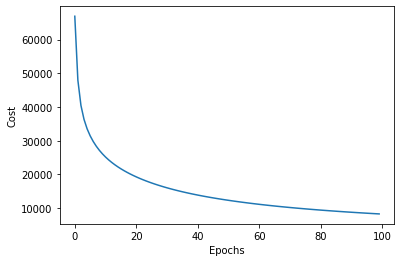

In [13]:
import matplotlib.pyplot as plt

plt.plot(range(nn.epochs), nn.eval_['cost'])
plt.ylabel('Cost')
plt.xlabel('Epochs')
#plt.savefig('images/12_07.png', dpi=300)
plt.show()

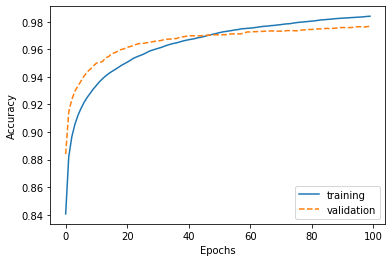

In [14]:
plt.plot(range(nn.epochs), nn.eval_['train_acc'], 
         label='training')
plt.plot(range(nn.epochs), nn.eval_['valid_acc'], 
         label='validation', linestyle='--')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
#plt.savefig('images/12_08.png', dpi=300)
plt.show()

In [15]:
y_test_pred = nn.predict(X_test)

acc = (np.sum(y_test == y_test_pred)
       .astype(np.float) / X_test.shape[0])

print('Test accuracy: %.2f%%' % (acc * 100))

Test accuracy: 97.04%
